# 1 Loading and Exploring the Data

In [64]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt 
from datetime import datetime, timedelta
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import mplleaflet

# The Data is part of the Kaggle Competition: https://www.kaggle.com/c/sf-crime/data
df_train = pd.read_csv("data/sf-crime/train.csv")
df_test = pd.read_csv("data/sf-crime/test.csv")

print(df_train.describe())
df_train.head()

                   X              Y
count  878049.000000  878049.000000
mean     -122.422616      37.771020
std         0.030354       0.456893
min      -122.513642      37.707879
25%      -122.432952      37.752427
50%      -122.416420      37.775421
75%      -122.406959      37.784369
max      -120.500000      90.000000


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [65]:
# Create a unique list of categories
print(np.unique(df_train['Category']))

['ARSON' 'ASSAULT' 'BAD CHECKS' 'BRIBERY' 'BURGLARY' 'DISORDERLY CONDUCT'
 'DRIVING UNDER THE INFLUENCE' 'DRUG/NARCOTIC' 'DRUNKENNESS'
 'EMBEZZLEMENT' 'EXTORTION' 'FAMILY OFFENSES' 'FORGERY/COUNTERFEITING'
 'FRAUD' 'GAMBLING' 'KIDNAPPING' 'LARCENY/THEFT' 'LIQUOR LAWS' 'LOITERING'
 'MISSING PERSON' 'NON-CRIMINAL' 'OTHER OFFENSES'
 'PORNOGRAPHY/OBSCENE MAT' 'PROSTITUTION' 'RECOVERED VEHICLE' 'ROBBERY'
 'RUNAWAY' 'SECONDARY CODES' 'SEX OFFENSES FORCIBLE'
 'SEX OFFENSES NON FORCIBLE' 'STOLEN PROPERTY' 'SUICIDE' 'SUSPICIOUS OCC'
 'TREA' 'TRESPASS' 'VANDALISM' 'VEHICLE THEFT' 'WARRANTS' 'WEAPON LAWS']


In [66]:
# let's explore what information we can extract from the streetnames
for i in df_train['Address'][0:20]:
    print(i)

OAK ST / LAGUNA ST
OAK ST / LAGUNA ST
VANNESS AV / GREENWICH ST
1500 Block of LOMBARD ST
100 Block of BRODERICK ST
0 Block of TEDDY AV
AVALON AV / PERU AV
KIRKWOOD AV / DONAHUE ST
600 Block of 47TH AV
JEFFERSON ST / LEAVENWORTH ST
JEFFERSON ST / LEAVENWORTH ST
0 Block of ESCOLTA WY
TURK ST / JONES ST
FILLMORE ST / GEARY BL
200 Block of WILLIAMS AV
0 Block of MENDELL ST
EDDY ST / JONES ST
GODEUS ST / MISSION ST
MENDELL ST / HUDSON AV
100 Block of JONES ST


# 2 Data Preprocessing

In [67]:
# Processing Function for Features
def cart2polar(x, y):
    dist = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return dist, phi

def preprocessFeatures(dfx):
    
    # Time Feature Engineering
    df = pd.get_dummies(dfx[['DayOfWeek' , 'PdDistrict']])
    df['Hour_Min'] = pd.to_datetime(dfx['Dates']).dt.hour + pd.to_datetime(dfx['Dates']).dt.hour/60
    df['Day'] = pd.to_datetime(dfx['Dates']).dt.day
    df['Month'] = pd.to_datetime(dfx['Dates']).dt.month
    df['Year'] = pd.to_datetime(dfx['Dates']).dt.year

    month_one_hot_encoded = pd.get_dummies(pd.to_datetime(dfx['Dates']).dt.month, prefix='Month')
    df = pd.concat([df, month_one_hot_encoded], axis=1, join="inner")
    
    # Convert Carthesian Coordinates to Polar Coordinates
    df[['X', 'Y']] = dfx[['X', 'Y']]
    df['dist'], df['phi'] = cart2polar(df['X'], df['Y'])
  
    # Extracting Street Types
    df['Is_ST'] = dfx['Address'].str.contains(" ST", case=True)
    df['Is_AV'] = dfx['Address'].str.contains(" AV", case=True)
    df['Is_WY'] = dfx['Address'].str.contains(" WY", case=True)
    df['Is_TR'] = dfx['Address'].str.contains(" TR", case=True)
    df['Is_DR'] = dfx['Address'].str.contains(" DR", case=True)
    df['Is_Block'] = dfx['Address'].str.contains(" Block", case=True)
    df['Is_crossing'] = dfx['Address'].str.contains(" / ", case=True)
    
    return df

# Processing Function for Labels
def encodeLabels(dfx):
    df = pd.DataFrame (columns = [])
    factor = pd.factorize(dfx['Category'])
    return factor

# Remove Outliers by Longitude
df_cleaned = df_train[df_train['Y']<70]

# Encode Labels as Integer
factor = encodeLabels(df_cleaned)
y_df = factor[0]
labels = list(factor[1])
for val, i in enumerate(labels):
    print(val, i)

# Create train_df & test_df
x_df = preprocessFeatures(df_cleaned).copy()

# Split the data into x_train and y_train data sets
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, train_size=0.7, random_state=0)
x_train

0 WARRANTS
1 OTHER OFFENSES
2 LARCENY/THEFT
3 VEHICLE THEFT
4 VANDALISM
5 NON-CRIMINAL
6 ROBBERY
7 ASSAULT
8 WEAPON LAWS
9 BURGLARY
10 SUSPICIOUS OCC
11 DRUNKENNESS
12 FORGERY/COUNTERFEITING
13 DRUG/NARCOTIC
14 STOLEN PROPERTY
15 SECONDARY CODES
16 TRESPASS
17 MISSING PERSON
18 FRAUD
19 KIDNAPPING
20 RUNAWAY
21 DRIVING UNDER THE INFLUENCE
22 SEX OFFENSES FORCIBLE
23 PROSTITUTION
24 DISORDERLY CONDUCT
25 ARSON
26 FAMILY OFFENSES
27 LIQUOR LAWS
28 BRIBERY
29 EMBEZZLEMENT
30 SUICIDE
31 LOITERING
32 SEX OFFENSES NON FORCIBLE
33 EXTORTION
34 GAMBLING
35 BAD CHECKS
36 TREA
37 RECOVERED VEHICLE
38 PORNOGRAPHY/OBSCENE MAT


,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,...,Y,dist,phi,Is_ST,Is_AV,Is_WY,Is_TR,Is_DR,Is_Block,Is_crossing
276998,0,0,0,0,0,1,0,0,0,0,...,37.785023,128.110900,2.842200,True,False,False,False,False,True,False
81579,0,0,0,0,0,1,0,0,0,0,...,37.748470,128.185052,2.842677,False,True,False,False,False,True,False
206676,0,0,0,1,0,0,0,0,0,0,...,37.762744,128.113657,2.842389,True,False,False,False,False,True,False
732006,0,0,0,0,0,0,1,0,0,0,...,37.784140,128.109653,2.842204,True,False,False,False,False,False,True
796194,1,0,0,0,0,0,0,0,0,0,...,37.791333,128.125982,2.842185,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359783,0,1,0,0,0,0,0,0,0,0,...,37.785745,128.105231,2.842180,True,False,False,False,False,False,True
152315,0,0,0,1,0,0,0,0,0,0,...,37.783386,128.108378,2.842207,True,False,False,False,False,True,False
117952,0,0,0,0,0,1,0,0,0,0,...,37.783053,128.109942,2.842214,True,False,False,False,False,True,False
435829,0,0,0,1,0,0,0,0,0,0,...,37.786565,128.106822,2.842178,True,False,False,False,False,True,False


# 3 Visualization

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]),
 <a list of 39 Text xticklabel objects>)

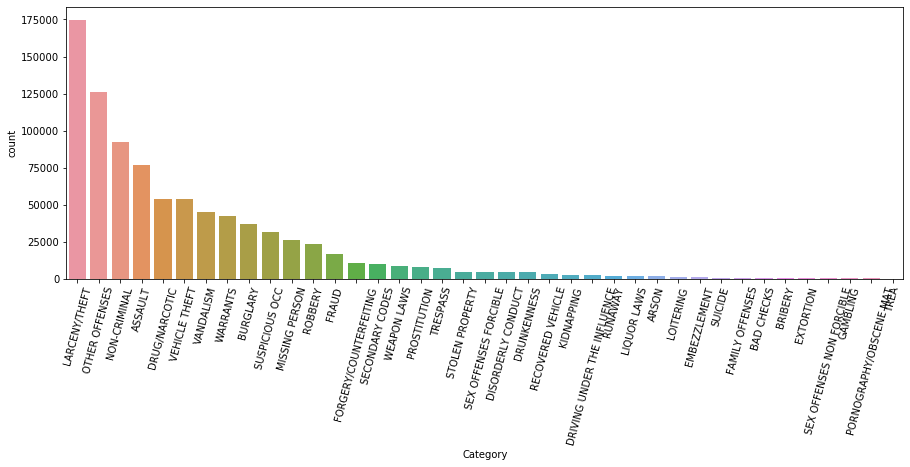

In [68]:
plt.figure(figsize=(15,5))
sns.countplot(x = df_cleaned['Category'], orient='v', order = df_cleaned['Category'].value_counts().index)
plt.xticks(rotation=75)


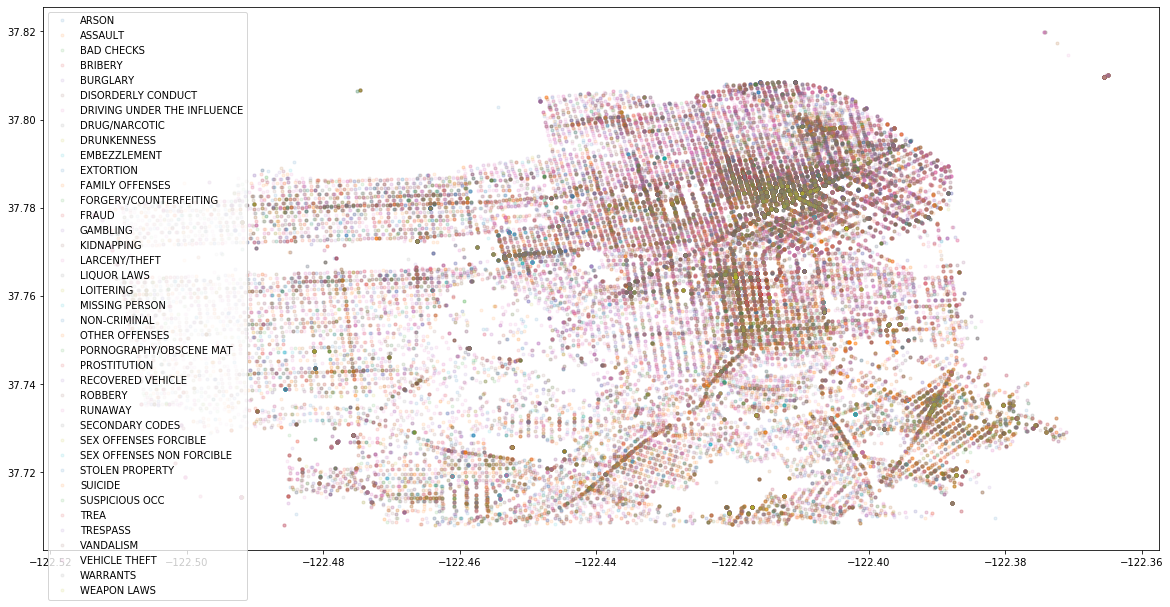

In [69]:
# Plot Criminal Activities by Lat and Long
df_filtered = df_cleaned.sample(frac=0.15)  
#df_filtered = df_cleaned[df_cleaned['Category'].isin(['PROSTITUTION', 'VEHICLE THEFT', 'FRAUD'])].sample(frac=0.05) # to filter 

groups = df_filtered.groupby('Category')

fig, ax = plt.subplots(sharex=False, figsize=(20, 10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['X'], group['Y'], marker='.', linestyle='', label=name, alpha=0.1)
ax.legend()
plt.show()

In [70]:
# Visualize Criminal Activities on a Geo Map
fig, ax = plt.subplots(sharex=False, figsize=(20, 10))
for name, group in groups:
    ax.plot(group['X'], group['Y'], marker='.', linestyle='', label=name, alpha=0.1)
mplleaflet.show()

# 4 Model Training

In [ ]:
# Train a single random forest classifier - parameters are a best guess
clf = RandomForestClassifier(max_depth=60, random_state=0, n_estimators = 100)
clf.fit(x_train, y_train.ravel())
y_pred = clf.predict(x_test)

results_log = classification_report(y_test, y_pred)
print(results_log)

In [ ]:
# # Random Search
# import xgboost as xgb

# dtrain = xgb.DMatrix(x_train, label=y_train)
# dtest = xgb.DMatrix(x_test, label=y_test)

# param = {'max_depth': 100, 'eta': 1, 'objective': 'multi:softmax', 'predictor': 'gpu_predictor', 'num_class': 39}
# num_round = 1
# evallist = [(dtest, 'eval'), (dtrain, 'train')]
# bst = xgb.train(param, dtrain, num_round, evallist)

# y_pred = bst.predict(dtest)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
import xgboost

rf_clf = RandomForestClassifier(max_depth=20, random_state=50, n_jobs=-1, verbose=3)
xg_clf = xgboost.XGBClassifier()

estimators = [
            ("rf", rf_clf),
            ("xg", xg_clf)
]

voting_clf = VotingClassifier(estimators, n_jobs=-1, voting="soft")
voting_clf.fit(x_train, y_train)
voting_clf.score(x_test, y_test)

In [ ]:
y_pred = voting_clf.predict_proba(x_test)
pred_df = pd.DataFrame(y_pred, columns=[voting_clf.classes_])
pred_df["Id"]= list(range(pred_df.shape[0]))
pred_df.to_csv("crime_pred_02.zip", compression="zip", index=False)
pred_df.head()

# 5 Model Testing

In [ ]:
results_log = classification_report(y_test, y_pred)
print(results_log)

In [ ]:
# Multi-Class Confusion Matrix
cnf_matrix = confusion_matrix(y_test.values.reshape(-1), y_pred)
df_cm = pd.DataFrame(cnf_matrix, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (30,14))
plt.tight_layout()
sns.set(font_scale=1.4) #for label size
sns.heatmap(df_cm, cbar=False, cmap= "YlGnBu", annot=True, fmt='.0f', annot_kws={"size": 13})